# **CONSIGNA #################**
Clasificación - Entrenamiento y Predicción

El objetivo será predecir el valor del atributo is_canceled, los modelos deberán entrenarse con
los datos de train y se deberán realizar las tareas de ingeniería de características necesarias
para trabajar con cada algoritmo (encoding, normalización, balanceo, etc)

---
Checkpoint 2 : Árbol de decisión

A. Construir árboles de decisión y optimizar sus hiperparámetros mediante k-fold
Cross Validation para obtener la mejor performance. ¿Cuántos folds utilizaron?
¿Qué métrica consideran adecuada para buscar los parámetros?

B. Graficar el árbol de decisión con mejor performance encontrado en el punto
anterior. Si es muy extenso mostrar una porción representativa.

C. Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y
decisiones evaluadas (explicar las primeras reglas obtenidas).

D. Evaluar la performance del modelo en entrenamiento y validación, explicar todas
las métricas y mostrar la matriz de confusión.

E. Generar predicciones con el conjunto de test y realizar los submits
correspondientes en la competencia de Kaggle.

# <center>Trabajo Práctico 1: Reservas de Hotel</center>

## <center>Organización de Datos</center>
#### <center>Cátedra Ing. Rodriguez, Juan Manuel </center>

Grupo 32 - Kung Fu Pandas

Integrantes:
* Daniel Agustin Marianetti - Padrón: 106256
* Franco Rodriguez - Padrón: 102815
* Ezequiel Lazarte - Padrón: 108063

Importamos las librerias que vamos a utilizar

In [54]:
!pip install 'dtreeviz'

In [55]:
import pandas as pd
import numpy as np
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.stats import randint

from six import StringIO
from IPython.display import Image
import pydotplus


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Descarga de datasets a utilizar

In [56]:
df_train_procesado = pd.read_csv('/content/drive/MyDrive/datasetsTP/hotels_train_procesado.csv')
df_trabajo = df_train_procesado.copy()

df_test_procesado = pd.read_csv('/content/drive/MyDrive/datasetsTP/hotels_test_procesado.csv')
df_trabajo_test = df_test_procesado.copy()

## Preprocesamiento

In [57]:
df_trabajo.drop(['meal', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'adults'], inplace=True, axis=1)
df_trabajo_test.drop(['meal', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'adults'], inplace=True, axis=1)

Ante las muchas iteraciones, pruebas y tras haber incluido datos de estas variables en las columnas agregadas, concluimos que terminan siendo contraproducentes al entrenar el modelo.

In [58]:
var_categoricas = set(['hotel', 'arrival_date_month',
                         'arrival_date_day_of_month', 'country',
                         'reserved_room_type', 'assigned_room_type',
                         'is_repeated_guest', 'deposit_type', 'agent',
                         'customer_type', 'distribution_channel', 'market_segment'])

label_encoder = preprocessing.LabelEncoder()

for col in df_trabajo.columns:
  if col in var_categoricas:
    df_trabajo[col] = label_encoder.fit_transform(df_trabajo[col])

for col in df_trabajo_test.columns:
  if col in var_categoricas:
    df_trabajo_test[col] = label_encoder.fit_transform(df_trabajo_test[col])

Aplicamos LabelEncoder a todas las variables que no sean numericas para poder utilizarlas

In [59]:
df_trabajo.drop(['id'], axis='columns', inplace=True)

# Obtengo los ids para agregarlos después y aprovecho a sacar la variable que no esta en el ds de train
ids_submit = df_trabajo_test['id']
df_trabajo_test.drop(['id', 'reservation_status_date'], axis='columns', inplace=True)

## Definición Set de Entrenamiento y Set de Test

In [60]:
df_trabajo_x = df_trabajo.drop(['is_canceled'], axis='columns')

df_trabajo_y = df_trabajo['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=3) #semilla

# Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 42777
# Datos Prueba: 18334
% Positivos Entrenamiento: 50.137
% Positivos Prueba: 50.180


## Arbol simple

In [61]:
from sklearn.ensemble import RandomForestClassifier

arbol_de_desicion = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 20,
                                         min_samples_leaf=10)

arbol_simple = arbol_de_desicion.fit(X = x_train, y = y_train)


In [62]:
y_pred_simple = arbol_simple.predict(x_test)

print('F1-Score: {}'.format(f1_score(y_test, y_pred_simple, average='binary')))

F1-Score: 0.8438116100766703


Realizamos la predicción sobre el set de test y calculamos el F1-score

## Arbol con optimización de hiperparametros sin poda

### Optimización de hiperparametros

mediante k-fold Cross Validation

In [63]:
#Cantidad de combinaciones que quiero porbar
n=20

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(7,9))}

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv_sin_poda = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv_sin_poda.fit(x_train,y_train);

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.


In [64]:
#Mejores hiperparametros del arbol
print(randomcv_sin_poda.best_params_)
#Mejor métrica
print(randomcv_sin_poda.best_score_)

{'max_depth': 8, 'criterion': 'entropy'}
0.8055975134633563


### Predicción y evaluación del modelo

In [65]:
arbol_optimizado_sin_poda = DecisionTreeClassifier().set_params(**randomcv_sin_poda.best_params_)

arbol_optimizado_sin_poda.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

Creo arbol con los mejores parametros

In [66]:
y_pred_sin_poda = arbol_optimizado_sin_poda.predict(x_test)

print('F1-Score: {}'.format(f1_score(y_test, y_pred_sin_poda, average='binary')))

F1-Score: 0.7979426033082003


Realizamos la predicción sobre el set de test y calculamos el F1-score

## Arbol con optimización de hiperparametros con poda

### Optimización de hiperparametros

mediante k-fold Cross Validation

In [67]:
n=25

params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,10)),
               'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.01,0.05,n),
               'max_depth':list(range(1,8))}

folds=5

kfoldcv = StratifiedKFold(n_splits=folds)

base_tree = DecisionTreeClassifier()

scorer_fn = make_scorer(f1_score)

randomcv_con_poda = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

randomcv_con_poda.fit(x_train,y_train);

In [68]:
print(randomcv_con_poda.best_params_)
print(randomcv_con_poda.best_score_)

{'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 6, 'criterion': 'entropy', 'ccp_alpha': 0.015}
0.8058339043911185


### Predicción y Evaluación del Modelo con mejores hiperparámetros

In [69]:
arbol_optimizado_con_poda = DecisionTreeClassifier().set_params(**randomcv_con_poda.best_params_)

arbol_optimizado_con_poda.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.015, criterion='entropy', max_depth=6,
                       min_samples_leaf=4, min_samples_split=9)

In [70]:
y_pred_con_poda = arbol_optimizado_con_poda.predict(x_test)

print('F1-Score: {}'.format(f1_score(y_test, y_pred_con_poda, average='binary')))

F1-Score: 0.8098748989202303


Realizamos la predicción sobre el set de test y calculamos el F1-score

## Mejor arbol obtenido tras iteraciones

Tras prueba y error, modificando repetidamente los hiperparámetros, llegamos a armar el siguiente árbol que resultó en el mayor porcentaje de aciertos en la competencia de Kaggle

In [71]:
n=20

folds=7

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

parametros = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
}

modelo = DecisionTreeClassifier(random_state=1)

mejor_randomcv = RandomizedSearchCV(
    estimator=modelo,
    param_distributions=parametros,
    n_iter=n,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_jobs=-1,
    random_state=1
)

mejor_randomcv.fit(x_train,y_train);

In [72]:
print(mejor_randomcv.best_params_)
print(mejor_randomcv.best_score_)

{'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 9, 'min_samples_split': 8}
0.85478683947883


In [73]:
mejor_arbol = DecisionTreeClassifier().set_params(**mejor_randomcv.best_params_)

mejor_arbol.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=16, min_samples_leaf=9,
                       min_samples_split=8)

In [74]:
mejor_y_pred = mejor_arbol.predict(x_test)

print('F1-Score: {}'.format(f1_score(y_test, mejor_y_pred, average='binary')))
print()

F1-Score: 0.8510593554492404



## Elección de mejor arbol

In [75]:
print("Metricas modelo 'simple'")
precision_arbol_simple=precision_score(y_test,y_pred_simple)
accuracy_arbol_simple=accuracy_score(y_test,y_pred_simple)
recall_arbol_simple=recall_score(y_test,y_pred_simple)
f1_arbol_simple=f1_score(y_test,y_pred_simple)

print("Precision: "+str(precision_arbol_simple))
print("Accuracy: "+str(accuracy_arbol_simple))
print("Recall: "+str(recall_arbol_simple))
print("f1 score: "+str(f1_arbol_simple))

print()

print("Metricas modelo sin poda")
precision_arbol_sin_poda=precision_score(y_test,y_pred_sin_poda)
accuracy_sin_poda=accuracy_score(y_test,y_pred_sin_poda)
recall_sin_poda=recall_score(y_test,y_pred_sin_poda)
f1_sin_poda=f1_score(y_test,y_pred_sin_poda)

print("Precision: "+str(precision_arbol_sin_poda))
print("Accuracy: "+str(accuracy_sin_poda))
print("Recall: "+str(recall_sin_poda))
print("f1 score: "+str(f1_sin_poda))

print()

print("Metricas modelo con poda")
precision_arbol_con_poda=precision_score(y_test,y_pred_con_poda)
accuracy_con_poda=accuracy_score(y_test,y_pred_con_poda)
recall_con_poda=recall_score(y_test,y_pred_con_poda)
f1_con_poda=f1_score(y_test,y_pred_con_poda)

print("Precision: "+str(precision_arbol_con_poda))
print("Accuracy: "+str(accuracy_con_poda))
print("Recall: "+str(recall_con_poda))
print("f1 score: "+str(f1_con_poda))

print()

print("Metricas mejor modelo")
precision_mejor=precision_score(y_test,mejor_y_pred)
accuracy_mejor=accuracy_score(y_test,mejor_y_pred)
recall_mejor=recall_score(y_test,mejor_y_pred)
f1_mejor=f1_score(y_test,mejor_y_pred)

print("Precision: "+str(precision_mejor))
print("Accuracy: "+str(accuracy_mejor))
print("Recall: "+str(recall_mejor))
print("f1 score: "+str(f1_mejor))

Metricas modelo 'simple'
Precision: 0.8503311258278146
Accuracy: 0.8444420202901712
Recall: 0.837391304347826
f1 score: 0.8438116100766703

Metricas modelo sin poda
Precision: 0.8630673915792135
Accuracy: 0.8114432202465365
Recall: 0.7419565217391304
f1 score: 0.7979426033082003

Metricas modelo con poda
Precision: 0.7200372155967183
Accuracy: 0.7819897458274244
Recall: 0.9253260869565217
f1 score: 0.8098748989202303

Metricas mejor modelo
Precision: 0.8241523266469809
Accuracy: 0.8454783462419548
Recall: 0.8797826086956522
f1 score: 0.8510593554492404


## Analisis mejor arbol

F1-Score: 0.8510593554492404



Text(50.722222222222214, 0.5, 'is_canceled')

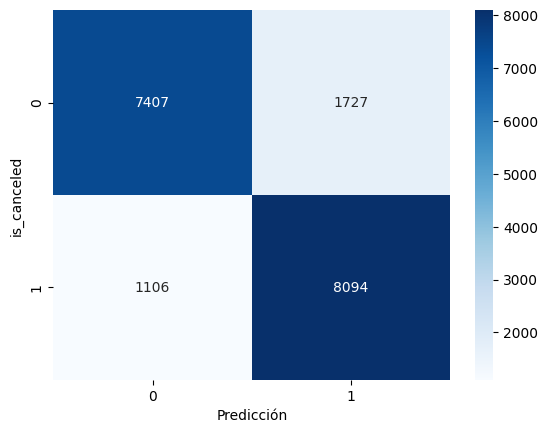

In [76]:
y_pred = mejor_arbol.predict(x_test)

print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))
print()

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción')
plt.ylabel('is_canceled')

Mostramos la matriz de confusión

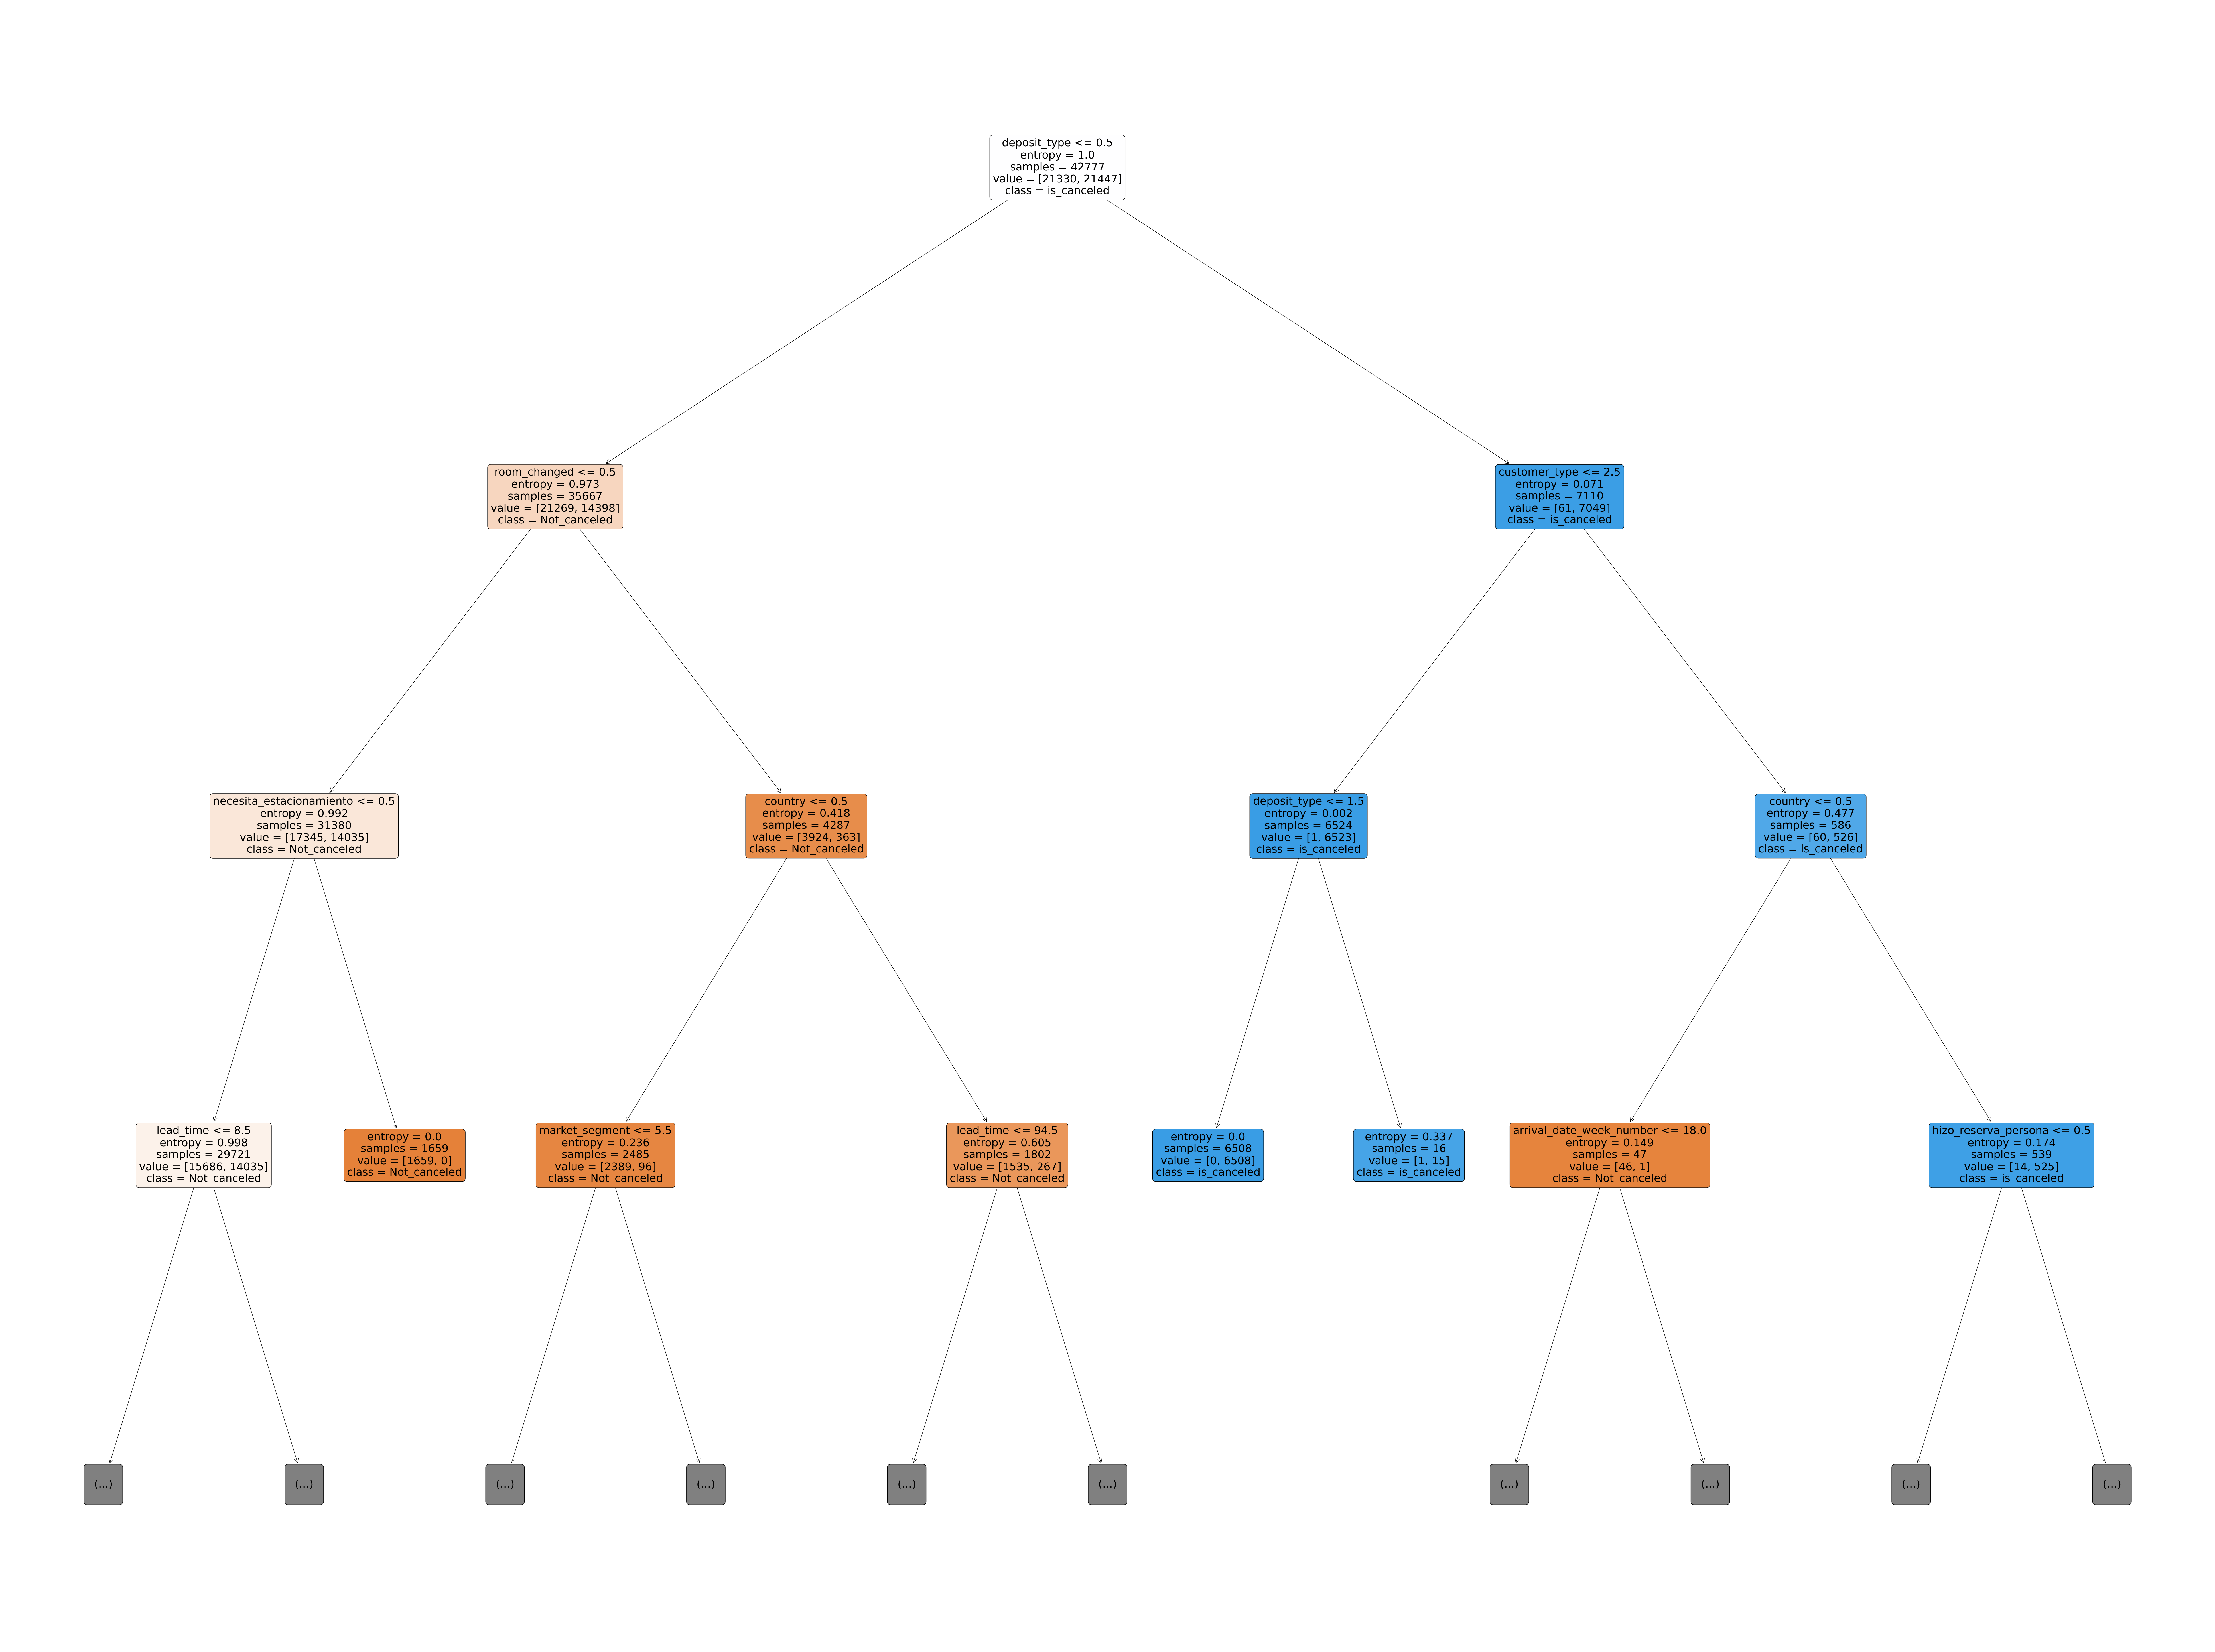

In [77]:
plt.figure(figsize=(100,75))

tree_plot=tree.plot_tree(mejor_arbol,
                         max_depth=3,
                         feature_names=df_trabajo_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=['Not_canceled','is_canceled'])

plt.show(tree_plot)

In [78]:
feat_imps = mejor_arbol.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_trabajo_x)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

company: 0.00014567809491997877
tiene_desayuno: 0.0002611899797725289
reserved_room_type: 0.0006508851870758332
hotel: 0.0011338622236204117
hijos: 0.0012818055087239363
is_repeated_guest: 0.0013024644497298338
total_de_personas: 0.001967199041962783
hizo_reserva_persona: 0.0022459348938527715
distribution_channel: 0.0026858707223879315
days_in_waiting_list: 0.0031219536092181475
stays_in_weekend_nights: 0.003324720397886483
tiene_cena: 0.0034404872472625758
stays_in_week_nights: 0.003821718168331942
assigned_room_type: 0.003898788042489431
total_dias: 0.0052396435030137665
arrival_date_month: 0.006071610286140412
booking_changes: 0.006364439073852012
hizo_requerimientos_especiales: 0.0066059748682442115
previous_bookings_not_canceled: 0.009343049479615466
arrival_date_day_of_month: 0.016488894914185048
arrival_date_week_number: 0.019660588765469257
customer_type: 0.02421357449751926
previous_cancellations: 0.025170958068188715
costo_total: 0.02570236267799598
arrival_date_year: 0.0269

# Predicción con mejor arbol en conjunto de test

In [79]:
submit_pred = mejor_arbol.predict(df_trabajo_test)
#Valores Predichos
submit_pred

array([1, 1, 0, ..., 1, 1, 0])

Realizamos una predicción sobre el set de test

In [80]:
df_submit = pd.DataFrame(zip(ids_submit,submit_pred),columns=['id','is_canceled'])
df_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           26535 non-null  object
 1   is_canceled  26535 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.7+ KB


Verificamos que contenga las columnas requeridas y un total de 26535 filas

In [81]:
df_submit.to_csv('/content/drive/MyDrive/datasetsTP/submit.csv', index = False)